In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dropout, Dense, BatchNormalization,Dot
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model


First change  movie and user id into sequence from 1 to number of movie or user

In [11]:
np.random.seed(100)
dataset = pd.read_csv("Movie Recommendation Lab/ratings.csv", header=0, names=['user_id', 'movie_id', 'rating'])
dataset.head(30)
movie_id_to_new_id = dict()
user_id_to_new_id = dict()
id = 1
user_id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])
        
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = user_id
        dataset.at[index, 'user_id'] = user_id
        user_id += 1
    else:
        dataset.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])
num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

Building model

In [12]:
latent_dim = 10
movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)
user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)
concat = Dot(axes=[1,1])([movie_vec, user_vec])
fc_1 = Dense(20, name='fc-1', activation='relu')(concat)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.5, name='fc-1-dropout')(fc_1_bn)
fc_2 = Dense(10, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.5, name='fc-2-dropout')(fc_2_bn)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)
model = Model([user_input, movie_input], fc_3)
model.compile(optimizer=adam_v2.Adam(lr=0.1), loss='mean_squared_error')

D:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 10)        14660       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 10)        23540       ['user-input[0][0]']             
                                                                                            

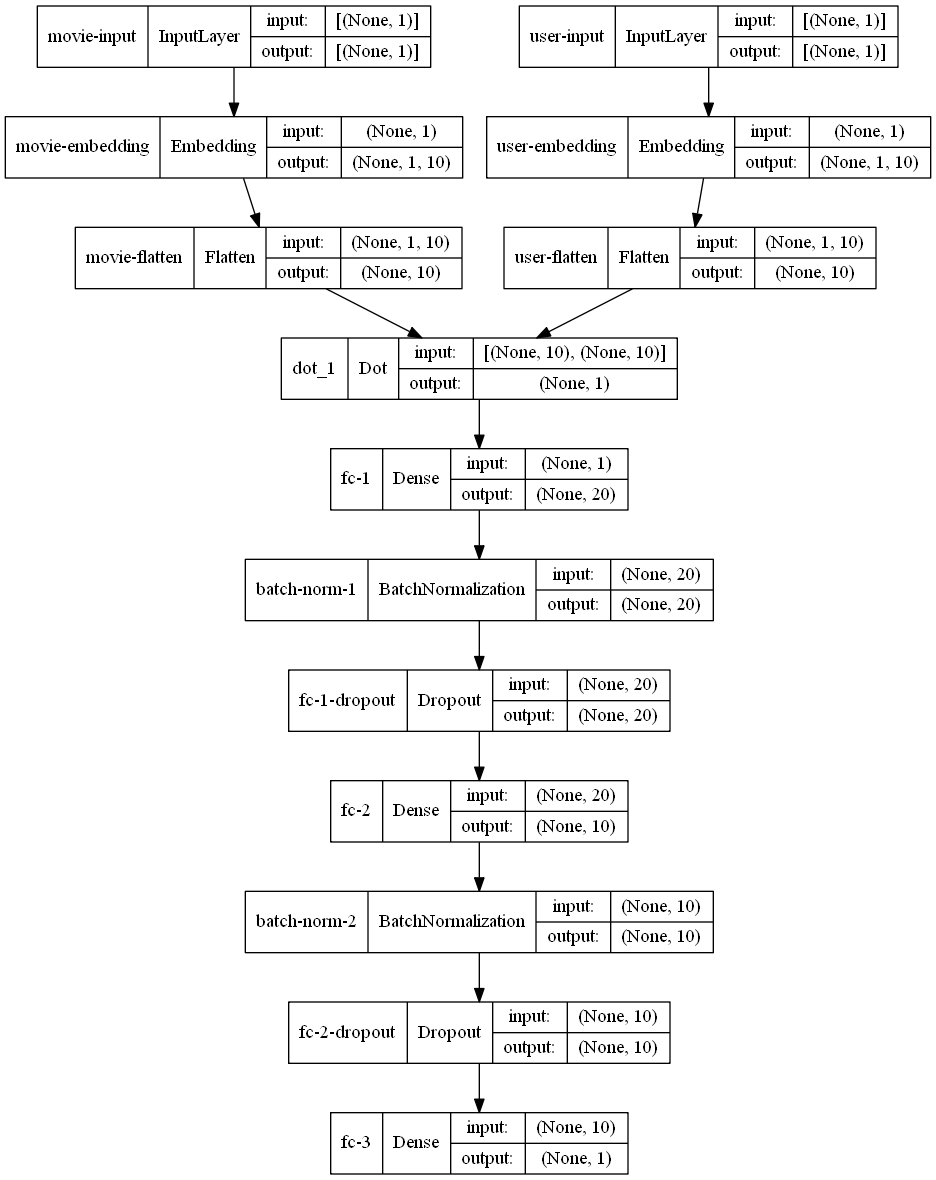

In [14]:
plot_model(model, to_file='model.png',show_shapes=True)

Train and Test

Epoch 1/30
791/791 [==============================] - 1s 767us/step - loss: 1.4008
Epoch 2/30
791/791 [==============================] - 1s 770us/step - loss: 1.2810
Epoch 3/30
791/791 [==============================] - 1s 782us/step - loss: 1.2868
Epoch 4/30
791/791 [==============================] - 1s 790us/step - loss: 1.2783
Epoch 5/30
791/791 [==============================] - 1s 794us/step - loss: 1.2650
Epoch 6/30
791/791 [==============================] - 1s 785us/step - loss: 1.2158
Epoch 7/30
791/791 [==============================] - 1s 765us/step - loss: 1.1621
Epoch 8/30
791/791 [==============================] - 1s 769us/step - loss: 1.1199
Epoch 9/30
791/791 [==============================] - 1s 761us/step - loss: 1.0528
Epoch 10/30
791/791 [==============================] - 1s 761us/step - loss: 0.9999
Epoch 11/30
791/791 [==============================] - 1s 861us/step - loss: 0.9707
Epoch 12/30
791/791 [==============================] - 1s 766us/step - loss: 0.9501
E

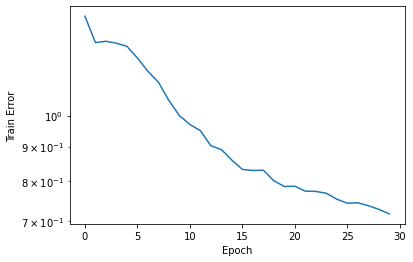

mean_absolute_error =  0.8486859655263377


In [15]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()
y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
print('mean_absolute_error = ',mean_absolute_error(y_true, y_hat))

In [16]:
mp = "NeuralMFmodel.h5"
model.save(mp)

In [17]:
print( y_hat[0:30])

[[3.81]
 [3.14]
 [3.41]
 [3.93]
 [2.96]
 [2.88]
 [3.64]
 [3.85]
 [3.29]
 [3.26]
 [4.03]
 [3.77]
 [4.08]
 [3.28]
 [3.3 ]
 [3.21]
 [3.78]
 [3.07]
 [1.86]
 [4.09]
 [4.07]
 [2.78]
 [3.17]
 [3.97]
 [3.31]
 [2.64]
 [4.13]
 [3.49]
 [4.07]
 [4.13]]


(array([2.000e+00, 4.000e+00, 1.400e+01, 2.900e+01, 6.400e+01, 1.560e+02,
        4.950e+02, 1.102e+03, 1.280e+03, 3.178e+03]),
 array([0.8      , 1.133    , 1.4660001, 1.799    , 2.132    , 2.4650002,
        2.798    , 3.131    , 3.464    , 3.7970002, 4.13     ],
       dtype=float32),
 <BarContainer object of 10 artists>)

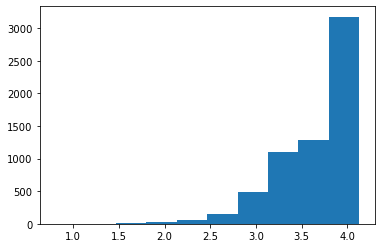

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


plt.hist(y_hat )